In [328]:
import os
import sys
from jax.config import config
import haiku as hk
import jax
from jax import numpy as jnp
import numpy as onp
import time
from jax.experimental.callback import rewrite
import tqdm

from bnn_hmc import data
from bnn_hmc import models
from bnn_hmc import nn_loss
from bnn_hmc import train_utils
from bnn_hmc import tree_utils
from bnn_hmc import precision_utils
from bnn_hmc import checkpoint_utils
from jax.experimental import optix
import functools

from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
tpu_ip = "10.0.0.2"
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://{}:8470".format(tpu_ip)

In [3]:
net_fn = models.make_mlp_regression(layer_dims=[100, 100, 100])
net = hk.transform_with_state(net_fn)
net_apply = net.apply
net_apply = jax.experimental.callback.rewrite(
  net_apply,
  precision_utils.HIH_PRECISION_RULES)

In [33]:
data_npz = onp.load("synth_reg_data.npz")
x_ = jnp.asarray(data_npz["x_"])
y_ = jnp.asarray(data_npz["y_"])
f_ = jnp.asarray(data_npz["f_"])
x = jnp.asarray(data_npz["x"])
y = jnp.asarray(data_npz["y"])
f = jnp.asarray(data_npz["f"])

In [15]:
x_.shape[0]

120

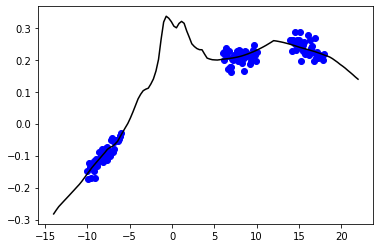

In [16]:
plt.plot(x, y, "bo")
plt.plot(x_, y_, "-k")

In [254]:
params, net_state = net.init(jax.random.PRNGKey(0), (f, None), True)

std = 0.
normal_key = jax.random.PRNGKey(0)

num_leaves = len(jax.tree_leaves(params))
normal_keys = list(jax.random.split(normal_key, num_leaves))
treedef = jax.tree_structure(params)
normal_keys = jax.tree_unflatten(treedef, normal_keys)
params = jax.tree_multimap(lambda p, key: jax.random.normal(key, p.shape) * std,
                           params, normal_keys)


In [255]:
noise_std = 0.02
prior_std = 0.1
weight_decay = 1 / prior_std**2

log_prior_fn, log_prior_diff_fn = (
    nn_loss.make_gaussian_log_prior(weight_decay=weight_decay))
log_likelihood_fn = nn_loss.make_gaussian_likelihood(noise_std=noise_std)

In [256]:
num_devices = len(jax.devices())
train_set = (f, y)
test_set = (f_, y_)
train_set = data.pmap_dataset(train_set, num_devices)
test_set = data.pmap_dataset(test_set, num_devices)

net_state = jax.pmap(lambda _: net_state)(jnp.arange(num_devices))

In [257]:
update, get_log_prob_and_grad, evaluate = train_utils.make_hmc_update(
    net_apply, log_likelihood_fn, log_prior_fn, log_prior_diff_fn,
    0., 0.)

In [258]:
log_prob, state_grad, log_likelihood, net_state = (
    get_log_prob_and_grad(train_set, params, net_state))
print(log_prob)

-39544.746


In [300]:
step_size=1e-5
trajectory_len = jnp.pi / 2 / jnp.sqrt(weight_decay)
print(trajectory_len)
trajectory_len = 0.157

0.15707964


In [460]:
0.157 / 1e-5

15699.999999999998

In [395]:
key = jax.random.PRNGKey(0)
all_pred_y_ = []
save_freq = 10

for iteration in tqdm.tqdm(range(201)):
    (params, net_state, log_likelihood, state_grad, step_size, key, accept_prob, accepted) = (
        update(train_set, params, net_state, log_likelihood, state_grad,
               key, step_size, trajectory_len, False))
    pred_y_, _ = net_apply(params, net_state, None, (f_, None), False)
    all_pred_y_.append(onp.asarray(pred_y_))
    
    if iteration % save_freq == 0:
        checkpoint_name = checkpoint_utils.make_checkpoint_name(iteration)
        checkpoint_dict = checkpoint_utils.make_hmc_checkpoint_dict(
            iteration, params, net_state, key, step_size, accepted, None,
            None)
        checkpoint_utils.save_checkpoint(checkpoint_name, checkpoint_dict)

100%|██████████| 201/201 [05:05<00:00,  1.52s/it]


In [398]:
log_likelihood

DeviceArray(-111.78056, dtype=float32)

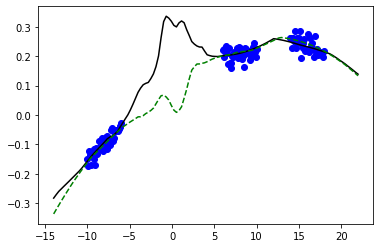

In [399]:
pred_y_, _ = net_apply(params, net_state, None, (f_, None), False)
plt.plot(x, y, "bo")
plt.plot(x_, y_, "-k")
plt.plot(x_, all_pred_y_[-1], "--g")

In [400]:
all_pred_y_stack_ = onp.concatenate([preds[None, :, 0] for preds in all_pred_y_])

In [401]:
pred_mean = onp.mean(all_pred_y_stack_, axis=0)
pred_std = onp.std(all_pred_y_stack_, axis=0)

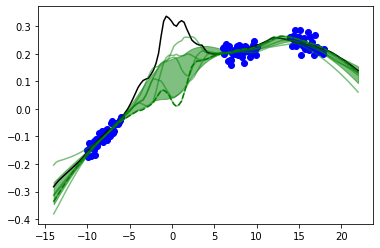

In [402]:
pred_y_, _ = net_apply(params, net_state, None, (f_, None), False)
plt.plot(x, y, "bo")
plt.plot(x_, y_, "-k")
plt.fill_between(x_, pred_mean + pred_std, pred_mean - pred_std, color="g", alpha=0.5)
plt.plot(x_, all_pred_y_[-1], "--g")
for preds in all_pred_y_stack_[::50]:
    plt.plot(x_, preds, alpha=0.5, color="g")

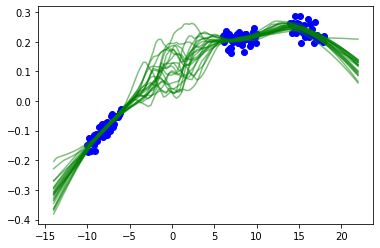

In [403]:
pred_y_, _ = net_apply(params, net_state, None, (f_, None), False)
plt.plot(x, y, "bo")
# plt.fill_between(x_, pred_mean + pred_std, pred_mean - pred_std, color="g", alpha=0.5)
for preds in all_pred_y_stack_[::10]:
    plt.plot(x_, preds, alpha=0.5, color="g")

## Loss Surface

In [418]:
def get_u_v_o(params1, params2, params3):
    def diff(a, b):
        return jax.tree_multimap(lambda p_a, p_b: p_a - p_b, a, b)
    def norm(a):
        return float(jnp.sqrt(sum([jnp.sum(p_a**2) for p_a in jax.tree_leaves(a)])))
    
#     print([p.shape for p in jax.tree_leaves(params1)])
    
    u_params = diff(params2, params1)
    u_norm = norm(u_params)
    u_params = tree_utils.tree_scalarmul(u_params, 1 / u_norm)
    v_params = diff(params3, params1)
    uv_dot = tree_utils.tree_dot(u_params, v_params)
    v_params = jax.tree_multimap(lambda v, u: v - uv_dot * u, v_params, u_params)
    v_norm = norm(v_params)
    v_params = tree_utils.tree_scalarmul(v_params, 1 / v_norm)
    
    return u_params, u_norm, v_params, v_norm, params1

In [465]:
checkpoint_dict = checkpoint_utils.load_checkpoint("model_step_10.pt")
params1 = checkpoint_dict["params"]

checkpoint_dict = checkpoint_utils.load_checkpoint("model_step_20.pt")
params2 = checkpoint_dict["params"]

checkpoint_dict = checkpoint_utils.load_checkpoint("model_step_30.pt")
params3 = checkpoint_dict["params"]

In [466]:
for params in [params1, params2, params3]:
    log_prob, _, _, _ = evaluate(params, net_state, train_set)
    print(log_prob)

-39002.66
-38845.758
-38983.406


In [ ]:
u_params, u_norm, v_params, v_norm, o_params = get_u_v_o(params1, params2, params3)

u_ts = onp.linspace(-.25, 1.25, 40)
v_ts = onp.linspace(-.25, 1.25, 40)
n_u, n_v = len(u_ts), len(v_ts)
log_probs = onp.zeros((n_u, n_v))
grid = onp.zeros((n_u, n_v, 2))

for u_i, u_t in enumerate(tqdm.tqdm(u_ts)):
    for v_i, v_t in enumerate(v_ts):
        grid[u_i, v_i] = [u_t, v_t]
        params = jax.tree_multimap(lambda u, v, o: o + u * u_t * u_norm + v * v_t * v_norm, 
                                   u_params, v_params, o_params)
        log_prob, _, _, _ = evaluate(params, net_state, train_set)
        log_probs[u_i, v_i] = float(log_prob)

  2%|▎         | 1/40 [00:02<01:43,  2.66s/it]

In [ ]:
log_probs_cliped = onp.clip(log_probs, -7.e4, 0)
plt.contour(grid[:, :, 0], grid[:, :, 1], log_probs_cliped, zorder=1)
plt.contourf(grid[:, :, 0], grid[:, :, 1], log_probs_cliped, zorder=0, alpha=0.55)
plt.plot([0., 1., 0.5], [0., 0., 1.], "ro", ms=20, markeredgecolor="k")